# Plot Benchmark results of [JaxRenderer](https://github.com/JoeyTeng/jaxrenderer)

Self-link: https://colab.research.google.com/drive/1gPsFGkF300zM-apwoKbUnvWLr8Ds4QeS

Research supported with Cloud TPUs from [Google's TPU Research Cloud (TRC)](https://sites.research.google/trc/).

In [ ]:
#@title Reinstall jaxrenderer from tag `v0.3.0`
!pip uninstall jaxrenderer -y -qqq
!pip install git+https://github.com/JoeyTeng/jaxrenderer.git@v0.3.0 -qqq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title ## Imports

from functools import partial
from typing import Optional
import os
import pickle

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.spatial.transform import Rotation as R

from renderer import CameraParameters as Camera
from renderer import LightParameters as Light
from renderer import ModelObject as Instance
from renderer import ShadowParameters as Shadow
from renderer import Renderer, merge_objects, transpose_for_display

from tqdm.auto import tqdm

In [ ]:
#@title ## Load data; Constants
!rm inputs-30.zip >/dev/null 2>&1
!rm inputs.pickle >/dev/null 2>&1
!wget -q https://github.com/JoeyTeng/jaxrenderer/raw/92904b74f4d760cd66b8940ed41c2d854cfbebe9/test_resources/pre-gen-brax/inputs-30.zip -O inputs-30.zip
!unzip -q inputs-30.zip

FRAMES_AVAILABLE: int = 30

_batched_instances, _batched_camera, _batched_target = pickle.load(open("inputs.pickle", "rb"))

_batched_instances = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_instances)
_batched_camera = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_camera)
_batched_target = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_target)

_one_instance = jax.tree_map(lambda a: a[0], _batched_instances)
_merged = merge_objects(_one_instance)

print("# of objects:", _merged.texture_shape.shape[0])
print("# of triangles:", _merged.faces.shape[0])
print("# of vertices:", _merged.verts.shape[0])

# of objects: 18
# of triangles: 3276
# of vertices: 9816


In [ ]:
#@title ## Benchmark Data

devices = ['base', 't4', 'a100', 'tpu_v2_8', 'tpu_v3_8']
names = ['PyTinyrenderer (baseline)', 'GPU NVIDIA T4', 'GPU NVIDIA A100', 'TPU v2-8', 'TPU v3-8']
tasks = ['32_32', '84_84', '480_270', '960_540']

#@markdown ### baseline
#@markdown [32x32](https://colab.research.google.com/drive/1Z-nH_wn-QZ_BcjlwK32N3GIlh7ZyWAwF)
base_32_32 = onp.array([
  [1, 330140148],
  [10, 2933522385],
  [20, 5851744055],
  [30, 8629593243],
  [100, 29161395377],
])
#@markdown [84x84](https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6)
base_84_84 = onp.array([
  [1, 298364846],
  [10, 2969032799],
  [20, 5862090458],
  [30, 8857799083],
  [100, 30003866457],
])
#@markdown [480x270](https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml)
base_480_270 = onp.array([
  [30, 9377981409],
  [300, 96434341083],
  [3000, 979216455444],
])
#@markdown [960x540](https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN)
base_960_540 = onp.array([
  [1, 504060638],
  [2, 952465938],
  [3, 950066929],
  [4, 1278338216],
  [5, 1597911073],
  [6, 1923835371],
  [7, 2263217720],
  [8, 2560599112],
  [9, 2945657038],
  [10, 3240611104],
  [11, 3606988233],
  [12, 4015624332],
  [13, 4235435864],
  [14, 4626957918],
  [15, 4957991577],
  [16, 5239959425],
  [17, 5526681954],
  [18, 5899238439],
  [19, 6177180479],
  [20, 6574626178],
  [21, 7054593490],
  [22, 7463854097],
  [23, 7821962094],
  [24, 8144671994],
  [25, 8393594712],
  [26, 8546603604],
  [27, 9137561998],
  [28, 9339753780],
  [29, 9699775568],
  [30, 9914164005],
])

#@markdown ### T4 Unroll = 1
#@markdown [32x32](https://colab.research.google.com/drive/1Z-nH_wn-QZ_BcjlwK32N3GIlh7ZyWAwF)
t4_32_32 = onp.array([
  [1, 8268056],
  [2, 9237552],
  [3, 10686017],
  [4, 12362604],
  [5, 13929825],
  [6, 15278806],
  [7, 16316343],
  [8, 18116531],
  [9, 19012430],
  [10, 19740629],
  [20, 27393949],
  [30, 41546445],
  [40, 49226766],
  [50, 60270662],
  [60, 71075619],
  [70, 82545638],
  [80, 93166697],
  [90, 104225053],
  [100, 115220949],
  [150, 171295255],
  [200, 226908307],
  [250, 283715463],
  [300, 339513753],
])
t4_unroll_32_32 = onp.array([
  [1, 38573549],
  [2, 41604704],
  [4, 45907489],
  [16, 46908113],
  [32, 43373440],
])
#@markdown [84x84](https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6)
t4_84_84 = onp.array([
  [1, 23484481],
  [2, 46449691],
  [3, 41339176],
  [4, 53725646],
  [5, 62746725],
  [6, 68328776],
  [7, 79141241],
  [8, 79697562],
  [9, 96325105],
  [10, 101148650],
  [20, 155487434],
  [30, 200143235],
  [40, 261258583],
  [50, 323890795],
  [60, 387316513],
  [70, 450235096],
  [80, 514293491],
  [90, 575141306],
  [100, 646234341],
  [200, 1321573223],
  [300, 1985781617],
])
t4_unroll_84_84 = onp.array([
  [1, 207116965],
  [2, 233724718],
  [4, 255167921],
  [16, 280449974],
  [32, 254675886],
  [42, 241061372],
])

t4_unroll_compilation_84_84 = onp.array([
  [1, 5586869959],
  [2, 6473700891],
  [4, 10280418887],
  [16, 24549850725],
  [32, 49808039379],
  [42, 39953838416],
])
#@markdown [480x270](https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml)
t4_480_270 = onp.array([
  [30, 3521039139],
  [300, 35870824734],
  [1500, 179091632579],
  [3000, 358249628419],
])
t4_unroll_480_270 = onp.array([
  [1, 3499834290],
  [2, 4018799304],
  [4, 4512406777],
  [16, 4879007576],
  [32, 4355216093],
])
#@markdown [960x540](https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN)
t4_960_540 = onp.array([
  [1, 619630879],
  [2, 1026871858],
  [3, 1512081420],
  [4, 1987420709],
  [5, 2451103774],
  [6, 2918876856],
  [7, 3393478118],
  [8, 3855982847],
  [9, 4309888374],
  [10, 4797336992],
  [11, 5243618771],
  [12, 5726694479],
  [13, 6197987727],
  [14, 6660710002],
  [15, 7156130623],
  [16, 7595193721],
  [17, 8073682221],
  [18, 8717982091],
  [19, 9001591483],
  [20, 9482766928],
  [21, 9959965678],
  [22, 10391201895],
  [23, 10829436694],
  [24, 11385438724],
  [25, 11797933450],
  [26, 12285653040],
  [27, 12976115387],
  [28, 13217230028],
  [29, 13648950986],
  [30, 14130158567],
])
t4_unroll_960_540 = onp.array([
  [1, 1010637901],
  [2, 1164108205],
  [3, 1212112185],
  [4, 1250310109],
  [16, 1341551028],
  [64, 1103941233],
  [192, 1107764211],
])

t4_960_540_compilation = onp.array([
  [1, 5467373775],
  [2, 5696650694],
  [3, 6634441999],
  [4, 7883848182],
  [16, 17044530316],
  [64, 50732766653],
  [192, 171307206135],
])
t4_960_540_compilation = onp.array([
  [1, 6860351172],
  [2, 6436860839],
  [3, 6830068403],
  [4, 7061889242],
  [5, 6437426957],
  [6, 6111870354],
  [7, 5582391475],
  [8, 5429528068],
  [9, 6862199025],
  [10, 5339570575],
  [11, 6335520312],
  [12, 5377760907],
  [13, 6324390853],
  [14, 5492177515],
  [15, 5379743669],
  [16, 5716696063],
  [17, 6000240308],
  [18, 6370426615],
  [19, 5718751790],
  [20, 5446674111],
  [21, 5734759601],
  [22, 6200304421],
  [23, 5333341756],
  [24, 6407607298],
  [25, 5377628417],
  [26, 6214358734],
  [27, 7184359705],
  [28, 5300718669],
  [29, 5470508548],
  [30, 5475130462],
])

#@markdown ### A100
#@markdown [32x32](https://colab.research.google.com/drive/180T5YOd3HaSILWBSl2nhzRbqMXT8_oO7)
a100_32_32 = onp.array([
  [1, 3947112],
  [2, 4755794],
  [3, 5058685],
  [4, 5331039],
  [5, 5401087],
  [6, 5638330],
  [7, 6059617],
  [8, 6177170],
  [9, 6457409],
  [10, 7057238],
  [20, 12426782],
  [30, 15630104],
  [40, 18942570],
  [50, 22895744],
  [60, 25883949],
  [70, 28258597],
  [80, 28579699],
  [90, 34526040],
  [100, 33666678],
  [150, 48781914],
  [200, 65152623],
  [250, 78653711],
  [300, 94591459],
])
a100_unroll_32_32 = onp.array([
  [1, 18430849],
  [2, 17880603],
  [4, 16806136],
  [16, 15690421],
  [32, 15588963],
])
#@markdown [84x84](https://colab.research.google.com/drive/1-lToQZ3ZGAVQrnHy39JfneM9iT2HOfaT) unroll = 32
a100_84_84 = onp.array([
  [1, 5854936],
  [2, 8800176],
  [3, 10394827],
  [4, 11800309],
  [5, 13685486],
  [6, 15464279],
  [7, 16271224],
  [8, 17950863],
  [9, 19199026],
  [10, 20908437],
  [20, 29951091],
  [30, 39385790],
  [40, 49961191],
  [50, 60648368],
  [60, 71331804],
  [70, 82157849],
  [80, 93047059],
  [90, 104439493],
  [100, 115088016],
  [200, 225078386],
])
a100_unroll_84_84 = onp.array([
  [1, 55462502],
  [2, 54149407],
  [4, 52459331],
  [16, 50442478],
  [32, 45543613],
  [42, 53915352],
])
#@markdown [480x270](https://colab.research.google.com/drive/1Mr2pRetdobZdgdtNT_DJuS4YZq3-C4oY) unroll = 32 due to long compilation time for unroll = 96 (~74s)
a100_480_270 = onp.array([
  [30, 641663589],
  [300, 5908003554],
  [1500, 29526901995],
  [3000, 59030282082],
])
a100_unroll_480_270 = onp.array([
  [1, 613618776],
  [2, 673936664],
  [4, 670971430],
  [16, 649309870],
  [32, 592734537],
  [96, 557898932],
])
#@markdown [960x540](https://colab.research.google.com/drive/1A7PzhG3vn6oNzrWTxE5E3dmu8xQTcNnH) unroll = 64
a100_960_540 = onp.array([
  [1, 134303425],
  [2, 215165081],
  [3, 280743384],
  [4, 352555107],
  [5, 415671180],
  [6, 483401680],
  [7, 549624319],
  [8, 615964585],
  [9, 682909404],
  [10, 749187381],
  [11, 814048568],
  [12, 883045986],
  [13, 951667301],
  [14, 1017319683],
  [15, 1086370406],
  [16, 1151643421],
  [17, 1200343468],
  [18, 1282046689],
  [19, 1347473401],
  [20, 1418262807],
  [21, 1482749043],
  [22, 1558449301],
  [23, 1622286297],
  [24, 1652089562],
  [25, 1717552157],
  [26, 1807875709],
  [27, 1868108715],
  [28, 1954692311],
  [29, 2002827384],
  [30, 2071264355],
])
a100_unroll_960_540 = onp.array([
  [1, 258989703],
  [2, 260569160],
  [3, 256503592],
  [4, 237489787],
  [16, 229073328],
  [64, 181243144],
  [192, 19763034],
])

#@markdown ### TPU v2-8 Unroll = 1
#@markdown Research supported with Cloud TPUs from [Google's TPU Research Cloud (TRC)](https://sites.research.google/trc/).

#@markdown [32x32](https://colab.research.google.com/drive/1uJbZl9I_EmwmV4bMFnbMpR3FLZjJ0nA2)
tpu_v2_8_32_32 = onp.array([
  [1, 50176555],
  [2, 89707906],
  [3, 96608904],
  [4, 105726437],
  [5, 109347915],
  [6, 114631732],
  [7, 127748918],
  [8, 135848048],
  [9, 1141436358],
  [10, 1176905812],
  [20, 1236945336],
  [30, 1287153122],
  [40, 280780286],
  [50, 1374051167],
  [60, 1432477592],
  [70, 1489862446],
  [80, 456127324],
  [90, 1557802080],
  [100, 1593917629],
  [150, 1815889031],
  [200, 965577372],
])
tpu_v2_8_unroll_32_32 = onp.array([
  [1, 1294996575],
  [2, 1352488280],
  [4, 1268116594],
  [8, 1367472230],
  [16, 1397445655],
])

#@markdown [84x84](https://colab.research.google.com/drive/1wQBr5iXYAlnp1QBPPpP-2gFGfGM5XCpg)
tpu_v2_8_84_84 = onp.array([
  [1, 155003557],
  [2, 197398161],
  [3, 202831266],
  [4, 208936003],
  [5, 215070807],
  [6, 223760827],
  [7, 230559494],
  [8, 241749352],
  [9, 1374386044],
  [10, 1409248069],
  [20, 1568860554],
  [30, 1747147452],
  [40, 797177535],
  [50, 2133124411],
  [60, 2255920543],
  [70, 2418488909],
  [80, 1485721208],
  [90, 2886307693],
  [100, 2979171926],
  [150, 3827868915],
  [200, 3560350663],
])
tpu_v2_8_unroll_84_84 = onp.array([
  [1, 1705639675],
  [2, 1731820119],
  [4, 1755110993],
  [16, 2327062490],
  [21, 2319407888],
])

#@markdown ### TPU v3-8 Unroll = 2
#@markdown [32x32](https://www.kaggle.com/joeyteng/benchmark-jaxrenderer-32x32)
tpu_v3_8_32_32 = onp.array([
  [1, 75631094],
  [2, 139010551],
  [3, 145762874],
  [4, 163437377],
  [5, 175296115],
  [6, 188794001],
  [7, 199918621],
  [8, 218343825],
  [9, 552586195],
  [10, 629967181],
  [20, 678202531],
  [30, 729913109],
  [40, 338796219],
  [50, 746617321],
  [60, 804669956],
  [70, 862370531],
  [80, 471592789],
  [90, 880514039],
  [100, 927069758],
  [150, 1127102356],
  [200, 875057156],
])
tpu_v3_8_unroll_32_32 = onp.array([
  [1, 736871278],
  [2, 730987645],
  [4, 723836065],
  [8, 714490876],
  [16, 737430095],
  [32, 717263637],
])

#@markdown [84x84](https://www.kaggle.com/joeyteng/benchmark-jaxrenderer-84x84)
tpu_v3_8_84_84 = onp.array([
  [1, 156193360],
  [2, 224109684],
  [3, 243723204],
  [4, 240123904],
  [5, 258410334],
  [6, 273181547],
  [7, 284031629],
  [8, 295490282],
  [9, 716952940],
  [10, 769129404],
  [20, 926627737],
  [30, 1054905897],
  [40, 724205907],
  [50, 1308134461],
  [60, 1425357674],
  [70, 1556516265],
  [80, 1231219587],
  [90, 1819428716],
  [100, 1952518244],
  [150, 2591676840],
  [200, 2754678414],
])
tpu_v3_8_unroll_32_32 = onp.array([
  [1, 1059727085],
  [2, 1037425441],
  [4, 1069908437],
  [16, 1100584432],
  [32, 1072818132],
  [42, 1107383409],
  [84, 1105520242],
])

In [ ]:
#@title ## Process data
def get_df(tasks, devices, names):
  times = dict()
  fps = dict()
  for task in tasks:
    data = dict()
    for j, device in enumerate(devices):
      recording = globals()[f"{device}_{task}"]
      for num_frames, execution_time_ns in recording:
        data.setdefault(num_frames, dict())[j] = execution_time_ns

    keys = sorted(data.keys())

    df_buffer = onp.zeros((len(keys), len(devices)), dtype=onp.float64)
    for i, key in enumerate(keys):
      for j in range(len(devices)):
        df_buffer[i, j] = data[key].get(j, onp.nan)

    # / 10**6 to convert nanoseconds to milliseconds
    df_buffer /= 10**6
    times[task] = pd.DataFrame(df_buffer, index=keys, columns=names)
    fps_buffer = 1000 * onp.array(keys)[:, None] / df_buffer
    fps[task] = pd.DataFrame(fps_buffer, index=keys, columns=names)

  return times, fps

times, fps = get_df(tasks[:2], devices, names)
big_canvas_times, big_canvas_fps = get_df(tasks[2:], devices[:-2], names[:-2])

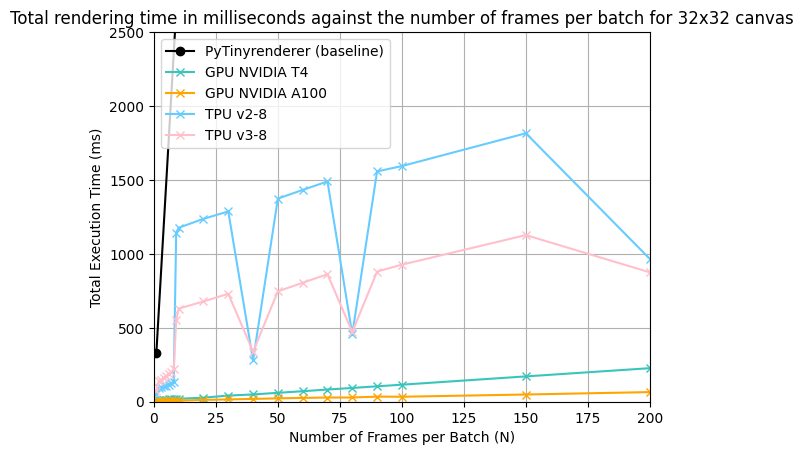

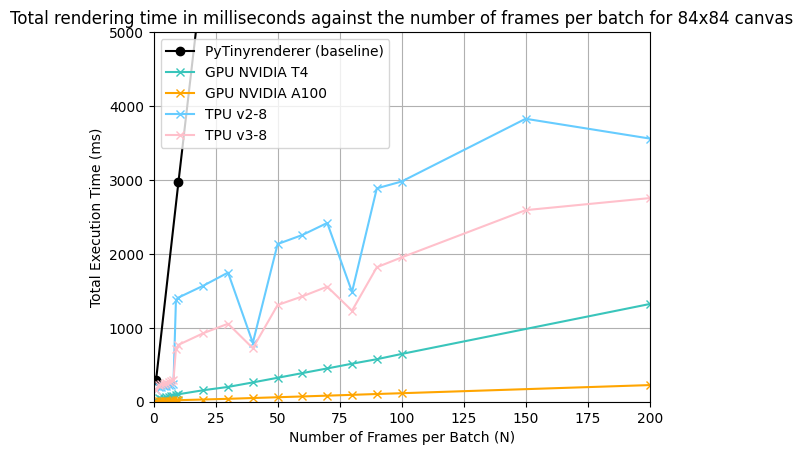

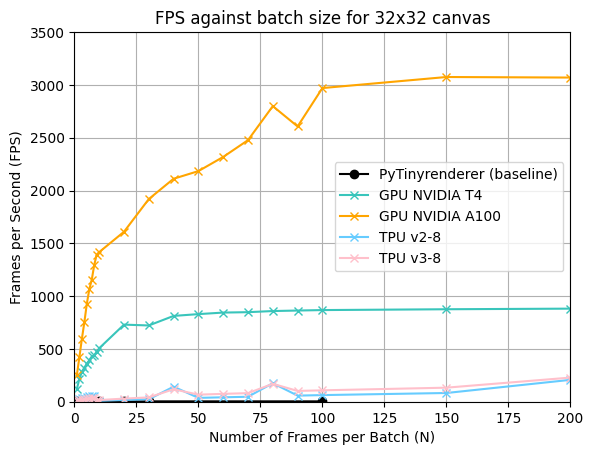

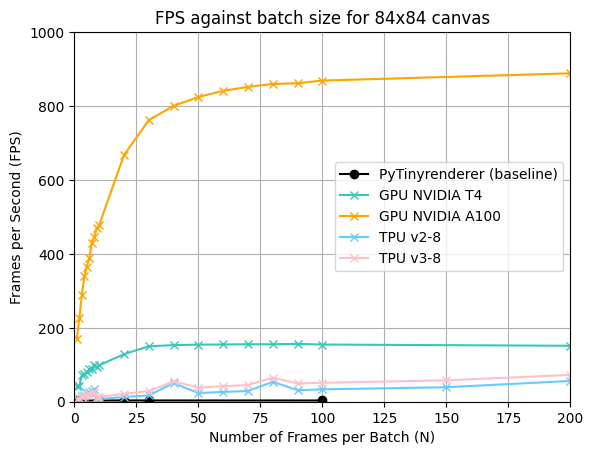

In [ ]:
#@title ## Visualise
#           black     MIKU Green RIN Yellow Tianyi Blue LUKA Pink
colours = ["#000000", "#39C5BB", "#FFA500", "#66CCFF", "#FFC0CB"]
markers = ["o", "x", "x", "x", "x"]
def plot(df, xlabel, ylabel, title, xlim, ylim, device_indices=range(len(devices)), ax=None):
  if ax is None:
    fig, ax = plt.subplots()

  ax.set_xlim(*sorted(xlim)[:2])
  ax.set_ylim(*sorted(ylim)[:2])

  tmp = list(zip(names, colours, df.columns))
  for i in device_indices:
    name, color, column = tmp[i]
    data = df[column]
    ax.plot(data[~onp.isnan(data)], label=name, color=color, marker=markers[i])

  ax.grid()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.legend()

fig, ax1, ax2 = plt.subplots(ncols=2, fig_size=(12, 4.8))

plot(
    times[tasks[0]],
    xlabel="Number of Frames per Batch (N)",
    ylabel="Total Execution Time (ms)",
    title="Total rendering time in milliseconds against the number of frames per batch for 32x32 canvas",
    xlim=(0, 200),
    ylim=(0, 2500),
)
plot(
    times[tasks[1]],
    xlabel="Number of Frames per Batch (N)",
    ylabel="Total Execution Time (ms)",
    title="Total rendering time in milliseconds against the number of frames per batch for 84x84 canvas",
    xlim=(0, 200),
    ylim=(0, 5000),
)
plot(
    fps[tasks[0]],
    xlabel="Number of Frames per Batch (N)",
    ylabel="Frames per Second (FPS)",
    title="FPS against batch size for 32x32 canvas",
    xlim=(0, 200),
    ylim=(0, 3500),
)
plot(
    fps[tasks[1]],
    xlabel="Number of Frames per Batch (N)",
    ylabel="Frames per Second (FPS)",
    title="FPS against batch size for 84x84 canvas",
    xlim=(0, 200),
    ylim=(0, 1000),
)

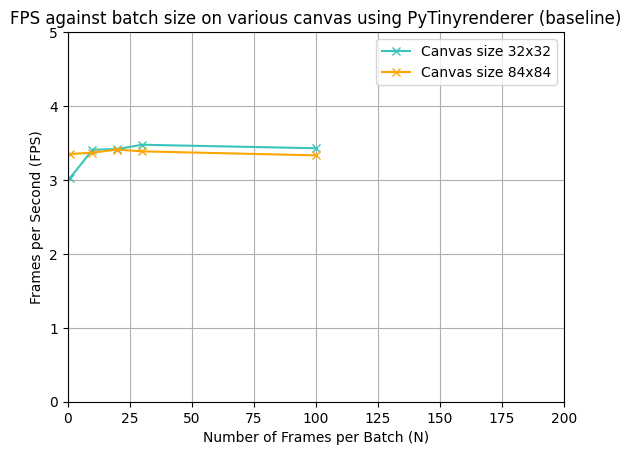

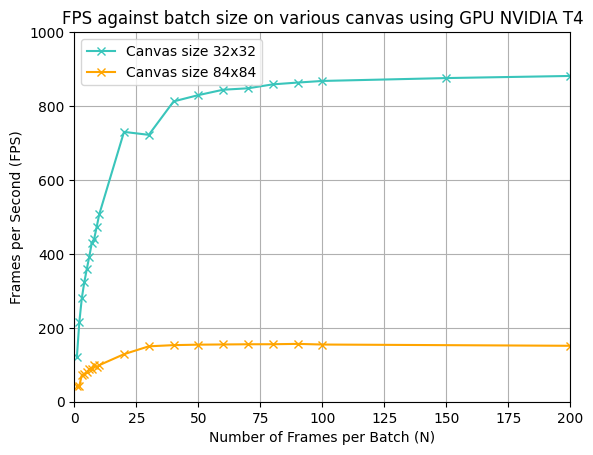

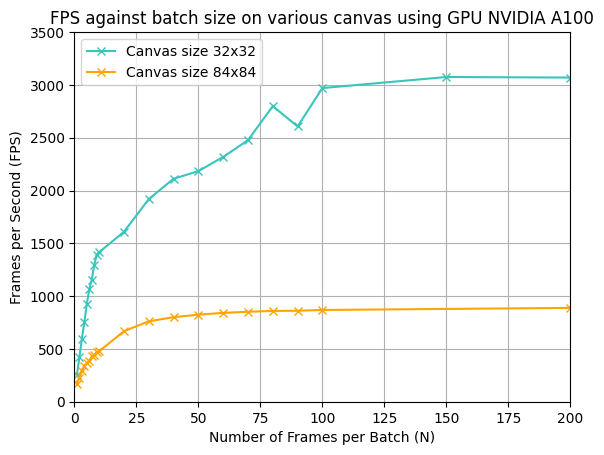

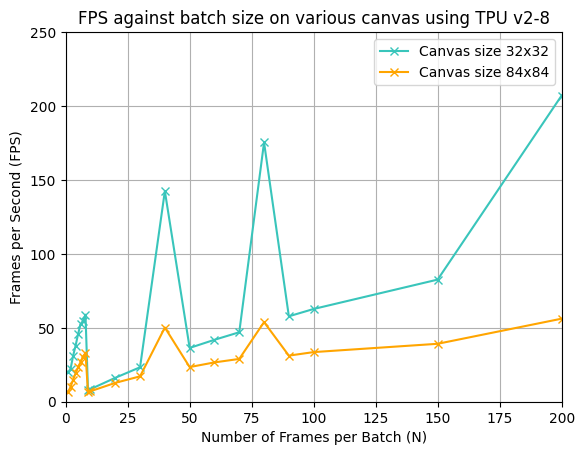

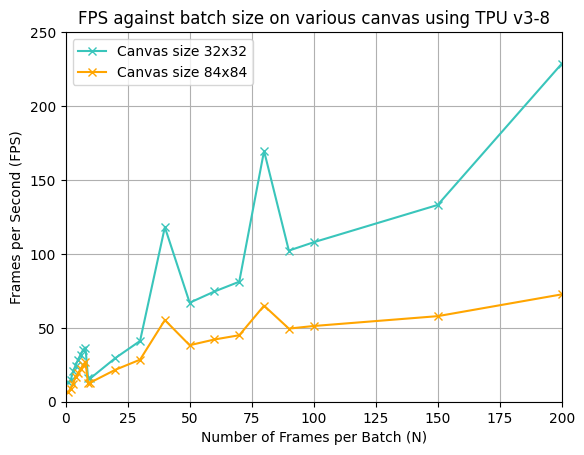

In [ ]:
#@title ## Visualise
#          MIKU Green RIN Yellow Tianyi Blue LUKA Pink
colours = ["#39C5BB", "#FFA500", "#66CCFF", "#FFC0CB"]
markers = ["x", "x", "x", "x"]
def plot(dfs, column_key, names, xlabel, ylabel, title, xlim, ylim):
  fig, ax = plt.subplots()

  ax.set_xlim(*sorted(xlim)[:2])
  ax.set_ylim(*sorted(ylim)[:2])

  for df, name, color, marker in zip(dfs, names, colours, markers):
    data = df[column_key]
    ax.plot(data[~onp.isnan(data)], label=name, color=color, marker=marker)

  ax.grid()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.legend()

ylims = [(0, 5), (0, 1000), (0, 3500), (0, 250), (0, 250)]

for device_name, ylim in zip(names, ylims):
  plot(
      [fps[task] for task in tasks[:2]],
      column_key=device_name,
      names=[f'Canvas size {size.replace("_", "x")}' for size in tasks[:2]],
      xlabel="Number of Frames per Batch (N)",
      ylabel="Frames per Second (FPS)",
      title=f"FPS against batch size on various canvas using {device_name}",
      xlim=(0, 200),
      ylim=ylim,
  )

In [ ]:
display(times[tasks[0]])

,CPU baseline Xeon,GPU NVIDIA T4,GPU NVIDIA A100,TPU v2-8,TPU v3-8
1,330.140148,8.268056,3.947112,50.176555,156.242268
2,NaN,9.237552,4.755794,89.707906,210.583914
3,NaN,10.686017,5.058685,96.608904,226.296320
4,NaN,12.362604,5.331039,105.726437,246.643607
5,NaN,13.929825,5.401087,109.347915,257.619083
6,NaN,15.278806,5.638330,114.631732,269.261793
7,NaN,16.316343,6.059617,127.748918,283.669168
8,NaN,18.116531,6.177170,135.848048,296.469712
9,NaN,19.012430,6.457409,1141.436358,698.408915
10,2933.522385,19.740629,7.057238,1176.905812,763.607526


In [ ]:
display(fps[tasks[0]])

,CPU baseline Xeon,GPU NVIDIA T4,GPU NVIDIA A100,TPU v2-8,TPU v3-8
1,3.029017,120.947415,253.349791,19.929626,6.400317
2,NaN,216.507577,420.539662,22.294579,9.497402
3,NaN,280.740710,593.039495,31.053038,13.256954
4,NaN,323.556429,750.322779,37.833489,16.217732
5,NaN,358.942054,925.739578,45.725609,19.408500
6,NaN,392.700843,1064.144880,52.341528,22.283147
7,NaN,429.017703,1155.188521,54.794985,24.676633
8,NaN,441.585644,1295.091442,58.889326,26.984207
9,NaN,473.374524,1393.747864,7.884802,12.886433
10,3.408871,506.569472,1416.984945,8.496857,13.095733


In [ ]:
display(fps[tasks[1]])

,CPU baseline Xeon,GPU NVIDIA T4,GPU NVIDIA A100,TPU v2-8,TPU v3-8
1,3.351601,42.581311,170.796060,6.451465,6.402321
2,NaN,43.057337,227.268182,10.131807,8.924202
3,NaN,72.570387,288.605092,14.790619,12.309045
4,NaN,74.452339,338.974174,19.144618,16.658067
5,NaN,79.685434,365.350562,23.248158,19.349071
6,NaN,87.810734,387.990931,26.814345,21.963416
7,NaN,88.449460,430.207340,30.360927,24.645143
8,NaN,100.379482,445.661025,33.092126,27.073648
9,NaN,93.433586,468.773781,6.548378,12.553125
10,3.368100,98.864394,478.275827,7.095983,13.001713


In [ ]:
#@title ## A100 on different scenes, using 32x32 canvas and 100 frames in batch
#@markdown [Colab](https://colab.research.google.com/drive/1n-K33VkFdWy_rzbQrK-szmgeL61jq7lw)

env_names = ["ant", "halfcheetah", "hopper", "humanoid", "humanoidstandup", "inverted_pendulum", "inverted_double_pendulum", "pusher", "reacher", "walker2d"]
_df_buffer = onp.array([
  [33489410, 3276, 9816],
  [17006393, 1548, 4632],
  [9818455, 780, 2328],
  [33462131, 3276, 9816],
  [33554193, 3276, 9816],
  [9225366, 576, 1728],
  [9720734, 780, 2328],
  [40272640, 3852, 11544],
  [18336528, 1740, 5208],
  [15838101, 1356, 4056],
], dtype=onp.float64)
_df_buffer_ms = _df_buffer.copy()
_df_buffer_ms[:, 0] /= 10**6
a100_scenes_time = pd.DataFrame(_df_buffer_ms, index=env_names, columns=["min execution time (ms)", "# of triangles", "# of vertices"])

_df_buffer_fps = _df_buffer.copy()
_df_buffer_fps[:, 0] = 100 / (_df_buffer[:, 0] / 10**9)
a100_scenes_fps = pd.DataFrame(_df_buffer_fps, index=env_names, columns=["max frames per second (FPS)", "# of triangles", "# of vertices"])

,max frames per second (FPS),# of triangles,# of vertices
ant,2986.018565,3276.0,9816.0
halfcheetah,5880.141662,1548.0,4632.0
hopper,10184.901800,780.0,2328.0
humanoid,2988.452827,3276.0,9816.0
humanoidstandup,2980.253466,3276.0,9816.0
inverted_pendulum,10839.678339,576.0,1728.0
inverted_double_pendulum,10287.289005,780.0,2328.0
pusher,2483.075358,3852.0,11544.0
reacher,5453.595141,1740.0,5208.0
walker2d,6313.888262,1356.0,4056.0


Text(0.5, 1.0, 'FPS against the number of triangles in a scene (rendering 100 32x32 images using NVIDIA A100)')

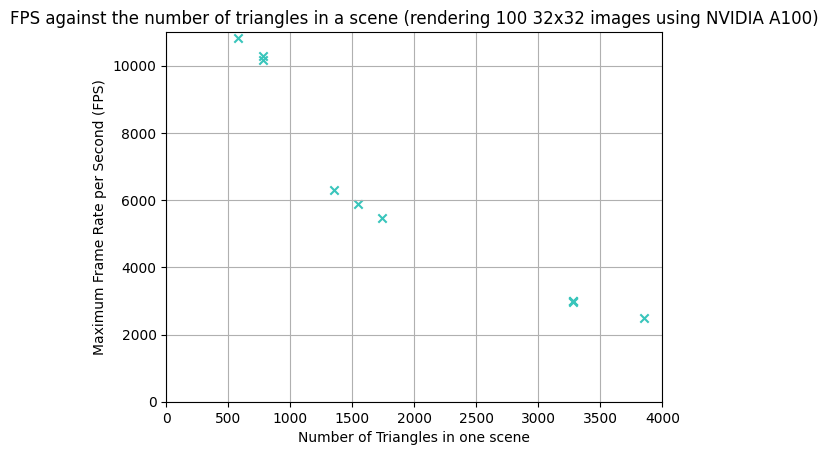

In [ ]:
#@title ## Visualise
display(a100_scenes_fps)

fig, ax = plt.subplots()

ax.set_xlim([0, 4000])
ax.set_ylim([0, 11000])

ax.scatter(a100_scenes_fps['# of triangles'], a100_scenes_fps['max frames per second (FPS)'], c="#39C5BB", marker="x")

ax.grid()
ax.set_xlabel("Number of Triangles in one scene")
ax.set_ylabel("Maximum Frame Rate per Second (FPS)")
ax.set_title("FPS against the number of triangles in a scene (rendering 100 32x32 images using NVIDIA A100)")